<a href="https://colab.research.google.com/github/Omar-Eladawy/NLP/blob/main/Final_M2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Dataset

In [56]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                
  inflating: train.csv               
  inflating: valid.csv               


In [80]:
!pip install
!pip install spacy
!pip install langdetect
!python -m spacy download en_core_web_sm
!pip install tensorflow


ERROR: You must give at least one requirement to install (see "pip help install")
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [58]:
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import csv
import pandas as pd
from collections import Counter
import math
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from spacy.tokens import Doc
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input , Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
s = pd.read_csv("train.csv",index_col=0,parse_dates=True)
df_Test =pd.read_csv("test.csv",index_col=0,parse_dates=True)
df_Valid =pd.read_csv("valid.csv",index_col=0,parse_dates=True)

<ipython-input-59-721f5a485840>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.read_csv("train.csv",index_col=0,parse_dates=True)
<ipython-input-59-721f5a485840>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_Test =pd.read_csv("test.csv",index_col=0,parse_dates=True)
<ipython-input-59-721f5a485840>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_Valid =pd.read_csv("valid.csv",index_col=0,parse_dates=True)


In [60]:
copy= s.copy()

In [61]:
copy['merged_column'] = copy['Title'] + copy['Body']

In [62]:
duplicates = copy.duplicated().sum()
duplicates
print(duplicates, "\n", copy.isna().sum())

0 
 Title            0
Body             0
Score            0
ViewCount        0
Label            0
LabelNum         0
merged_column    0
dtype: int64


No duplicates or null values ^^^

# Preprocessing


In [63]:
#function for model building and testing
import string
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens


In [64]:
stop_words = set(stopwords.words('english'))
copy['filtered_text'] = copy['merged_column'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
copy.drop(columns=['Title'], inplace=True)
copy.drop(columns=['Body'], inplace=True)
copy['filtered_text'] = copy['filtered_text'].str.replace('<p>', '')

In [65]:
def clean_text(text):
    cleaned_text = re.sub('<.*?>', ' ', text)
    cleaned_text = re.sub(r'/', ' ', cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]', ' ', cleaned_text)
    cleaned_text = cleaned_text.lower()
    return cleaned_text
copy['cleaned_column'] = copy['filtered_text'].apply(clean_text)
copy['tokenized_column'] = copy['cleaned_column'].apply(word_tokenize)

In [66]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
copy['lemmatized_column'] = copy['tokenized_column'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
#didnt remove verbs
copy.rename(columns={'lemmatized_column': 'without_verbs'}, inplace=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Analysis and Visualizations


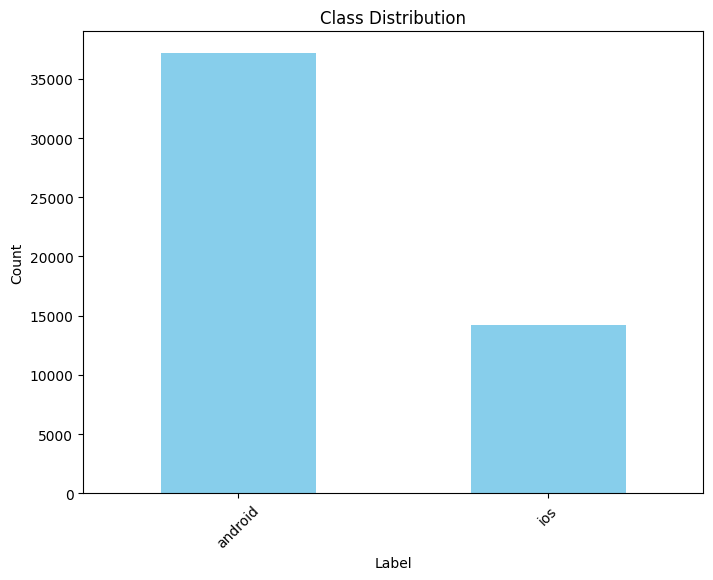

<Figure size 1000x600 with 0 Axes>

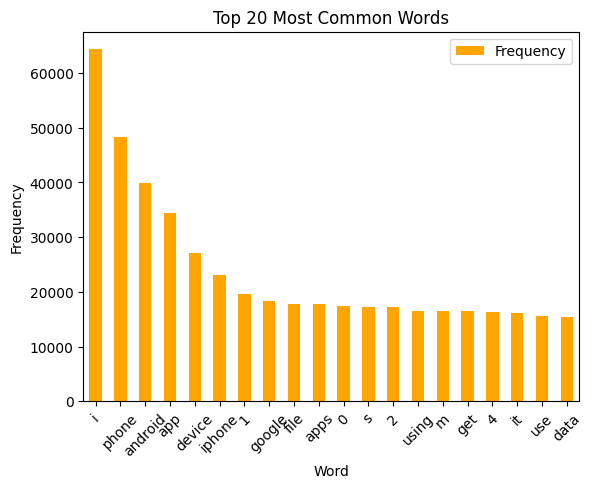

In [67]:
import matplotlib.pyplot as plt

# Class Distribution
plt.figure(figsize=(8, 6))
copy['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Word Frequency Distribution
from collections import Counter

# Flatten the lemmatized text into a single list of words
all_words = [word for tokens in copy['without_verbs'] for word in tokens]

# Calculate word frequencies
word_freq = Counter(all_words)

# Plot the most common words
plt.figure(figsize=(10, 6))
word_freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])
word_freq_df.plot(x='Word', y='Frequency', kind='bar', color='orange')
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


DF , IDF only for visualization

In [68]:
import numpy as np

def calculate_df(tokens_column):
    df = {}
    for tokens in tokens_column:
        unique_tokens = set(tokens)
        for token in unique_tokens:
            df[token] = df.get(token, 0) + 1
    return df

# Calculate Document Frequency (DF) for the entire 'without_verbs' column
df_without_verbs = calculate_df(copy['without_verbs'])

# Display the Document Frequency (DF) for tokens in the entire 'without_verbs' column
print("Document Frequency (DF) for tokens in the entire 'without_verbs' column:")
print(df_without_verbs)

Document Frequency (DF) for tokens in the entire 'without_verbs' column:
{'feature': 2410, 'this': 9008, 'non': 1289, 'conditionscan': 1, 'limit': 454, 'reach': 297, 'how': 5401, 'achieve': 437, 'wifi': 3390, '4': 8696, '2': 9509, 'android': 19023, 'period': 291, 'stop': 2055, 'version': 5421, 'connection': 2619, 'mobile': 3079, 'drop': 389, 'data': 6793, 'set': 4245, 'which': 1431, 'within': 909, 'prevent': 1019, 'nice': 450, 'such': 310, 'message': 5094, 'automatically': 1939, 'charged': 382, 'plan': 595, 'generally': 220, 'can': 11394, 'crop': 36, 'reached': 135, 'mm': 291, 'current': 1274, 'sm': 1704, 'text': 2427, 'free': 1753, 'sending': 763, 'character': 341, 'is': 8918, 'sent': 991, 'instead': 2052, 'overstepping': 1, 'long': 1870, 'not': 5959, 'use': 11030, 'way': 12071, 'app': 15243, 'it': 12291, 'conversation': 334, 't': 8883, 'go': 5036, 'corner': 246, 'notification': 2777, 'doe': 1892, 'john': 40, 'left': 1326, 'appears': 1520, 'groupwhen': 1, 'includes': 196, 'there': 394

In [69]:
import numpy as np

# Function to calculate Inverse Document Frequency (IDF) for each token
def calculate_idf(df, num_documents):
    idf = {}
    for token, freq in df.items():
        idf[token] = np.log(num_documents / freq)
    return idf

# Calculate the total number of documents (rows) in the dataframe
num_documents = len(copy)

# Calculate Document Frequency (DF) for the 'without_verbs' column
df_without_verbs = calculate_df(copy['without_verbs'])

# Calculate Inverse Document Frequency (IDF) for tokens in the 'without_verbs' column
idf_without_verbs = calculate_idf(df_without_verbs, num_documents)

print("Subset of Inverse Document Frequency (IDF) values for tokens in the 'without_verbs' column:")
for token, idf in list(idf_without_verbs.items())[:100]:
    print(f"Token: {token}, IDF: {idf}")

Subset of Inverse Document Frequency (IDF) values for tokens in the 'without_verbs' column:
Token: feature, IDF: 3.059427596976613
Token: this, IDF: 1.7409412730818419
Token: non, IDF: 3.685187620522126
Token: conditionscan, IDF: 10.846809623461313
Token: limit, IDF: 4.728712425419966
Token: reach, IDF: 5.153077484658614
Token: how, IDF: 2.252470222868422
Token: achieve, IDF: 4.766876428365723
Token: wifi, IDF: 2.7182244230868178
Token: 4, IDF: 1.7761911946602682
Token: 2, IDF: 1.6868156259218694
Token: android, IDF: 0.9934055710931723
Token: period, IDF: 5.173486356289821
Token: stop, IDF: 3.2187784965309785
Token: version, IDF: 2.2487740442009754
Token: connection, IDF: 2.9762617789536017
Token: mobile, IDF: 2.8144494755368132
Token: drop, IDF: 4.883230279842867
Token: data, IDF: 2.0231616742700114
Token: set, IDF: 2.493312524715866
Token: which, IDF: 3.5806808439048625
Token: within, IDF: 4.034464529283834
Token: prevent, IDF: 3.9202325902385886
Token: nice, IDF: 4.737562040696948
T

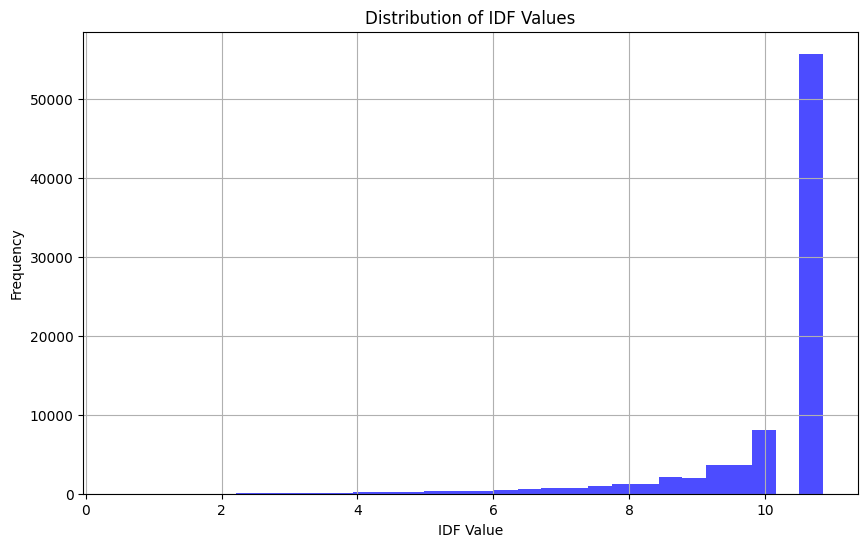

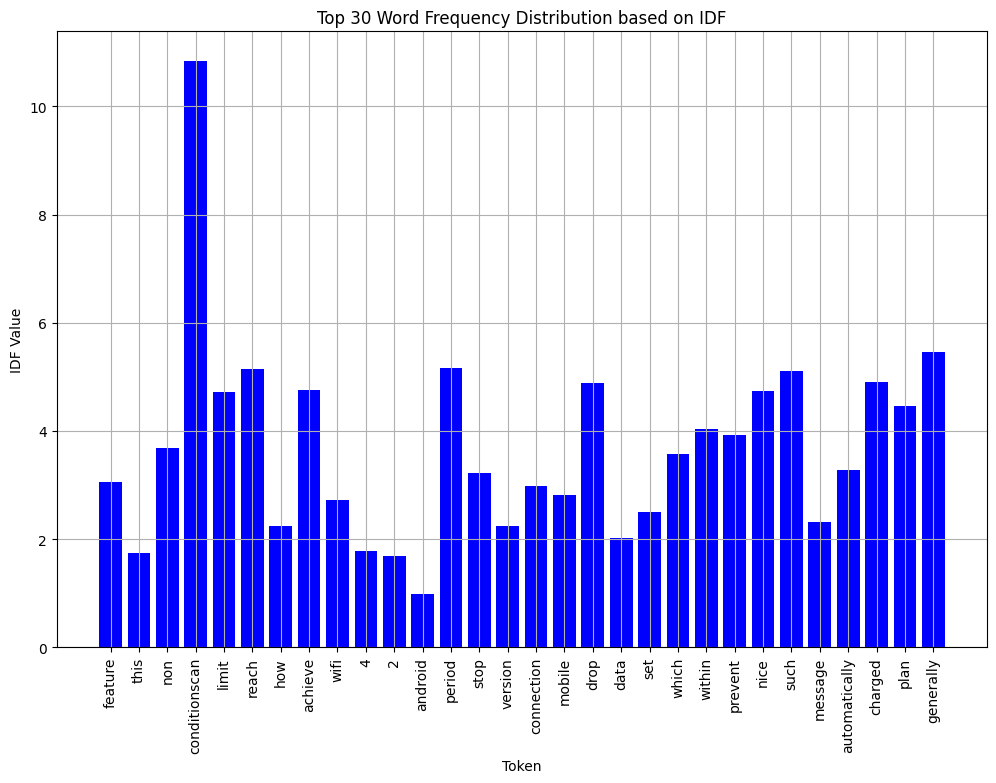

In [70]:
import matplotlib.pyplot as plt

# Convert IDF dictionary to lists for visualization
idf_tokens = list(idf_without_verbs.keys())
idf_values = list(idf_without_verbs.values())

# Data Distribution (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(idf_values, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of IDF Values')
plt.xlabel('IDF Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Word Frequency Distribution (Bar Plot)
plt.figure(figsize=(12, 8))
plt.bar(idf_tokens[:30], idf_values[:30], color='blue')
plt.title('Top 30 Word Frequency Distribution based on IDF')
plt.xlabel('Token')
plt.ylabel('IDF Value')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


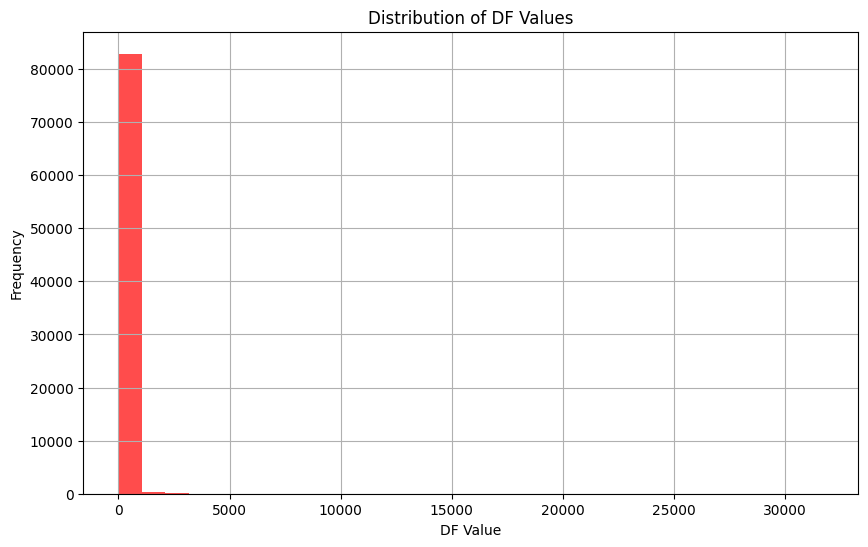

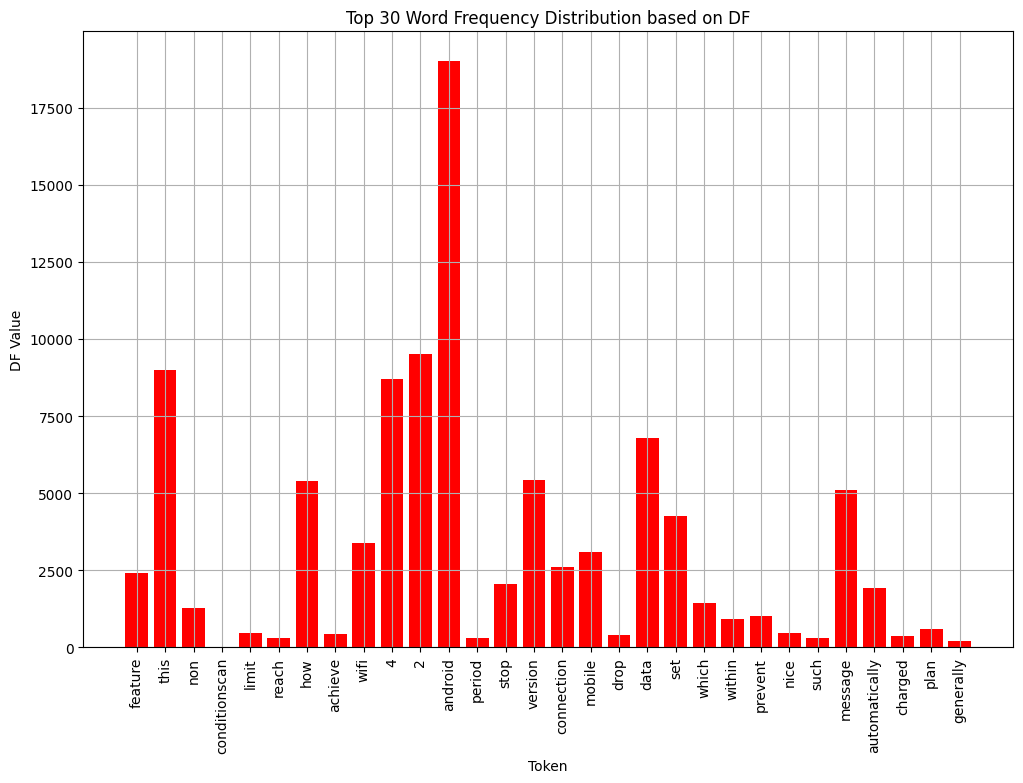

In [71]:
import matplotlib.pyplot as plt

# Convert DF dictionary to lists for visualization
df_tokens = list(df_without_verbs.keys())
df_values = list(df_without_verbs.values())

# Data Distribution (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(df_values, bins=30, color='red', alpha=0.7)
plt.title('Distribution of DF Values')
plt.xlabel('DF Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Word Frequency Distribution (Bar Plot)
plt.figure(figsize=(12, 8))
plt.bar(df_tokens[:30], df_values[:30], color='red')
plt.title('Top 30 Word Frequency Distribution based on DF')
plt.xlabel('Token')
plt.ylabel('DF Value')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# M2
using title and body to predict label

preprocessing


In [72]:
copy.rename(columns={'without_verbs': 'Text'}, inplace=True)

columns_to_remove = [ 'merged_column' ,'filtered_text','cleaned_column', 'tokenized_column']
copy.drop(columns=columns_to_remove, inplace=True)


In [73]:
from gensim.models import Word2Vec

# Assuming 'Text' column contains tokenized text data as lists of words
sentences = copy['Text'].tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


Word embeddung (Word2Vec)

Word2Vec to be used in ms3

In [ ]:
import numpy as np

def get_word2vec_vectors(word2vec_model, sentence, vector_size):
    """
    Convert a sentence to a list of Word2Vec vectors.
    """
    vectors = []
    for word in sentence:
        if word in word2vec_model.wv:
            vectors.append(word2vec_model.wv[word])
        else:
            vectors.append(np.zeros(vector_size))
    return vectors

# Define the maximum sequence length and vector size
max_seq_length = 100  # Adjust as needed
vector_size = word2vec_model.vector_size

# Convert each text sequence to a sequence of Word2Vec vectors
copy['Text_vectors'] = copy['Text'].apply(lambda x: get_word2vec_vectors(word2vec_model, x, vector_size))

# Pad sequences to ensure they have the same length to be used in pretrained model
def pad_sequences(vectors, max_seq_length, vector_size):
    """
    Pad sequences to the same length.
    """
    if len(vectors) < max_seq_length:
        padding = [np.zeros(vector_size)] * (max_seq_length - len(vectors))
        vectors.extend(padding)
    return np.array(vectors[:max_seq_length])

copy['Text_vectors_padded'] = copy['Text_vectors'].apply(lambda x: pad_sequences(x, max_seq_length, vector_size))

Binary classification model

In [74]:

def Word2Vec(sentence):
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(100)
Vectors = np.array([Word2Vec(sentence) for sentence in sentences])

In [75]:
Vectors

array([[-0.88397545, -0.57304007, -0.61339873, ..., -0.06391161,
         0.62086165,  0.17500672],
       [-0.7534614 , -0.1152701 , -0.6946969 , ...,  0.15913218,
         0.06471313, -0.11171232],
       [-0.48452854, -0.04162453, -0.59316695, ..., -0.00819932,
        -0.02558917, -0.46993554],
       ...,
       [-0.20046379,  0.13376833, -0.47460184, ..., -0.28930074,
         0.19856031,  0.32256183],
       [-0.41715372, -0.49113578, -1.0618948 , ..., -0.5872768 ,
         0.57287896,  0.7848808 ],
       [-0.23390219, -0.00321361, -0.61614317, ..., -0.14664213,
         0.636077  ,  0.30518734]], dtype=float32)

splitting data / can use test or valid file with same results

In [76]:
label = copy['LabelNum'].values
X_train, X_test, y_train, y_test = train_test_split(Vectors , label, test_size=0.2, random_state=42)

removed lstm layer

evaluation of the model

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential()
model.add(Dense(64, activation = 'relu' ,input_dim=100))
model.add(Dense(64, activation='relu', input_dim=100))
model.add(Dropout(0.2))
# Sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1028/1028 [==============================] - 4s 2ms/step - loss: 0.1147 - accuracy: 0.9574 - val_loss: 0.0908 - val_accuracy: 0.9682
Epoch 2/10
1028/1028 [==============================] - 5s 5ms/step - loss: 0.0836 - accuracy: 0.9707 - val_loss: 0.0875 - val_accuracy: 0.9696
Epoch 3/10
1028/1028 [==============================] - 3s 3ms/step - loss: 0.0771 - accuracy: 0.9722 - val_loss: 0.0791 - val_accuracy: 0.9706
Epoch 4/10
1028/1028 [==============================] - 3s 3ms/step - loss: 0.0740 - accuracy: 0.9734 - val_loss: 0.0787 - val_accuracy: 0.9709
Epoch 5/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.0711 - accuracy: 0.9738 - val_loss: 0.0774 - val_accuracy: 0.9709
Epoch 6/10
1028/1028 [==============================] - 3s 3ms/step - loss: 0.0672 - accuracy: 0.9750 - val_loss: 0.0906 - val_accuracy: 0.9634
Epoch 7/10
1028/1028 [==============================] - 3s 3ms/step - loss: 0.0637 - accuracy: 0.9769 - val_loss: 0.0723 - val_accuracy:

In [84]:
val_loss, val_accuracy = model.evaluate(X_test, y_test , batch_size=32)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

322/322 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.9727
Validation Loss: 0.07445523142814636
Validation Accuracy: 0.972746729850769


testing

In [100]:
import numpy as np

def euler_to_normal(euler_number):
    return format(euler_number, '.10f')

# Sample question (either iOS or Android)
question = input("Please enter your question: ")

# Process the question
processed_question = preprocess_text(question)

# Convert the processed question into a vector
question_vector = np.array([Word2Vec(processed_question)])

# Predict the label for the input question
predicted_label = model.predict(question_vector)

# Determine if it's more closely related to Android or iOS based on the predicted label
if predicted_label[0] < 0.5:
    print("Android results")
else:
    print("IOS results")

# Print Euler to Normal for the predicted label
print("From Euler to Normal:", euler_to_normal(predicted_label[0][0]))



Please enter your question: playstore
1/1 [==============================] - 0s 28ms/step
Android results
From Euler to Normal: 0.0000514226
